In [1]:
import numpy as np
import pandas as pd
import _pickle as pickle
from collections import defaultdict
import re
import ast

from bs4 import BeautifulSoup

import sys
import os
import json
import operator

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

from keras.optimizers import SGD

from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, GlobalAveragePooling1D, LSTM, GRU, Bidirectional, dot, multiply, Lambda, TimeDistributed, Masking

from keras.models import Model, Sequential
from keras.regularizers import l2,l1,l1_l2
from keras.callbacks import Callback,EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight

from keras.callbacks import Callback

from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, classification_report,accuracy_score, auc, roc_curve, roc_auc_score, average_precision_score


Using TensorFlow backend.


In [2]:
from gensim.models import Word2Vec

In [3]:
from keras.initializers import Constant

In [4]:
from keras import optimizers

In [5]:
import matplotlib.pyplot as plt

In [6]:
MAX_PARA_LENGTH = 70
MAX_PARAS = 70
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 100
#VALIDATION_SPLIT = 0.2
#lr = 0.0005
opt = optimizers.Adam(lr= 0.0005)
#l1_reg = l1(1e-5)
l12_reg = l1_l2(l1 = 1e-6,l2 = 1e-6)
BATCH_SIZE = 24
#metrics_auc = {}
metrics_prcs = {}
epochs_num = 200
#num_folder = 5
path = '/home/jujun/fraudprediction_10k/data/'
hanpath = '/home/jujun/fraudprediction_10k/HAN/'
date = '20200419'

In [7]:
def load_data(data_name):
    f = open(data_name,'rb')
    data = pickle.load(f)
    return data

In [8]:
raw_data = load_data('/home/jujun/fraudprediction_10k/data/rm_name/data_20200309_2012_rmname_smr')

In [9]:
with open('/home/jujun/fraudprediction_10k/data/word_index_50000_20200228','rb') as fp:
    word_index_5000 = pickle.load(fp)

In [29]:
len(word_index_5000)

50000

In [11]:
data = np.zeros((len(raw_data), MAX_PARAS, MAX_PARA_LENGTH), dtype='int32') 

In [12]:
data.shape

(56288, 70, 70)

In [15]:
# labels = []
# for r in raw_data:
#     labels.append(r[1])

text_para = []
for d in raw_data:
    text_para.append(d[-1])

# def generate_doc(x):
#     return ' '.join(x)

# text_doc = []
# for d in text_para:
#     text_doc.append(generate_doc(d))

# tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# tokenizer.fit_on_texts(text_doc)
# word_index = tokenizer.word_index
# print('Total %s unique tokens.' % len(word_index))

In [21]:
for i, doc in enumerate(text_para):
    #structure of a doc: [p1,p2,p3,p4]
    for j, para in enumerate(doc):
        
        if j < MAX_PARAS:
            wordTokens = text_to_word_sequence(para)
            
            k = 0
            for _, word in enumerate(wordTokens):
                try:
                    if k < MAX_PARA_LENGTH and word_index_5000[word] < MAX_NB_WORDS:
                        data[i, j, k] = word_index_5000[word]
                        k = k + 1
                except:
                    pass

In [22]:
data[0]

array([[ 586,    4, 3563, ...,    0,    0,    0],
       [ 109,   47,   13, ...,  572,  347,  345],
       [   2,  170,  363, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]], dtype=int32)

In [24]:
word_index_5000['guidance']

586

In [25]:
text_para[0][0]

" guidance and commonly accepted business practices pertaining to the new standards will not result in unexpected modifications to the company 's current revenue recognition practices which could materially adversely impact the company 's license fee revenue , results of operations and net income ."

In [26]:
np.save('/home/jujun/fraudprediction_10k/data/rm_name/handata_20200417_smr', data)

In [27]:
w2v_model = Word2Vec.load("/home/jujun/fraudprediction_10k/data/w2v_model_202002028.model")

In [30]:
embedding_matrix = np.zeros(((MAX_NB_WORDS+ 1) , EMBEDDING_DIM))
ignored=[]
cnt=0
for word, i in word_index_5000.items():
    if word in w2v_model.wv.vocab:
        embedding_vector = w2v_model[word]
        cnt+=1
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    else: ignored.append(word)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [36]:
print([k for k,v in word_index_5000.items() if v == 1])

['dd']


In [38]:
w2v_model.wv['dd']

array([-1.3283623 ,  1.41827   , -0.65882695, -1.6147015 ,  2.468268  ,
       -0.42368728, -4.4156685 , -1.3322588 ,  3.7734382 ,  0.7318338 ,
        4.3100348 , -1.4612162 ,  6.325748  ,  2.366124  , -6.921417  ,
       -1.182699  ,  1.480579  ,  2.2892702 , -2.5732665 , -0.69038177,
        4.0245414 , -0.5315669 , -1.1980819 ,  1.4395552 , -2.6943657 ,
        0.7361027 ,  4.8261    , -0.01021513,  0.21439712,  3.478016  ,
       -2.1577919 ,  2.8423629 , -4.420455  , -2.8044963 ,  6.279768  ,
       -2.4343824 , -4.0343623 , -0.8162619 , -0.6136432 ,  2.1052966 ,
        2.4300811 , -0.10685003,  2.3682425 , -1.4224614 ,  2.6889145 ,
        2.7072098 , -2.030083  ,  0.47402325, -3.7594397 ,  1.5625619 ,
        1.0157455 , -1.2497745 ,  1.099688  ,  0.5369321 ,  2.0262012 ,
       -0.3783232 ,  2.061828  , -1.6854526 , -0.02000618,  5.442802  ,
        3.142451  ,  2.1300676 ,  1.6364223 , -0.45857748,  0.8741788 ,
        2.7430117 ,  0.8213309 , -7.328257  ,  1.6280165 , -2.30

In [37]:
embedding_matrix[1]

array([-1.32836235,  1.41826999, -0.65882695, -1.61470151,  2.46826792,
       -0.42368728, -4.41566849, -1.33225882,  3.77343822,  0.73183382,
        4.31003475, -1.46121621,  6.32574797,  2.36612391, -6.92141724,
       -1.18269897,  1.48057902,  2.28927016, -2.57326651, -0.69038177,
        4.02454138, -0.53156692, -1.19808185,  1.43955517, -2.69436574,
        0.7361027 ,  4.82609987, -0.01021513,  0.21439712,  3.4780159 ,
       -2.15779185,  2.84236288, -4.42045498, -2.80449629,  6.27976799,
       -2.43438244, -4.03436232, -0.81626189, -0.61364323,  2.10529661,
        2.43008113, -0.10685003,  2.3682425 , -1.42246139,  2.68891454,
        2.70720983, -2.03008294,  0.47402325, -3.75943971,  1.56256187,
        1.01574552, -1.24977446,  1.09968805,  0.53693211,  2.02620125,
       -0.3783232 ,  2.0618279 , -1.68545258, -0.02000618,  5.44280195,
        3.14245105,  2.13006759,  1.63642228, -0.45857748,  0.87417883,
        2.74301171,  0.8213309 , -7.32825708,  1.62801647, -2.30

In [39]:
np.save('/home/jujun/fraudprediction_10k/data/rm_name/embedding_matrix_20200419', embedding_matrix)

In [47]:
train_indecis = load_data(path + 'indices_train_20200214')
#train_indecis = train_indecis[0:3000]
print(len(train_indecis))

test_indecis = load_data(path + 'indices_test_20200214')
#test_indecis = test_indecis[0:800]
print(len(test_indecis))

train_indecis_x, train_indecis_val = train_test_split(train_indecis, test_size=0.2, random_state=66)

X_train = data[train_indecis_x]
X_val = data[train_indecis_val]
X_test = data[test_indecis]

Y_train = pd.Series(labels)[train_indecis_x]
Y_val = pd.Series(labels)[train_indecis_val]
Y_test = pd.Series(labels)[test_indecis]

print("y train:", Y_train.value_counts())
print("y val:", Y_val.value_counts())
# y_test= pd.Series(test_labels)
print("y test:", Y_test.value_counts())

45030
11258
y train: 0    35710
1      314
dtype: int64
y val: 0    8915
1      91
dtype: int64
y test: 0    11157
1      101
dtype: int64


In [74]:
class_weights = {0: 1, 1:20.0}

val_sample_weights = []
for y in Y_val:
    if y == 1:
        val_sample_weights.append(class_weights[1])
    else: val_sample_weights.append(class_weights[0])
val_sample_weights = np.asarray(val_sample_weights)

In [49]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate


class Evaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            score_ap = average_precision_score(self.y_val, y_pred)
            logs['Avg_Prec'] = score_ap
            #tencile=performance_measure(y_pred, self.y_val)
            #logs['tencile'] = tencile
            print(" epoch:{:d} AUC: {:.4f}".format(epoch, score))
            print(" epoch:{:d} Avg_Prec: {:.4f}".format(epoch, score_ap))


# class PrecisionEvaluation(Callback):
#     """ Show average Precision after interval number of epoches """
#     def __init__(self, validation_data=(), interval=1):
#         super(Callback, self).__init__()
#         self.interval = interval
#         self.X_val, self.y_val = validation_data

#     def on_epoch_end(self, epoch, logs={}):
#         if epoch % self.interval == 0:
#             y_pred = self.model.predict(self.X_val, verbose=0)
#             score = average_precision_score(self.y_val, y_pred)
#             logs['Avg_Prec'] = score
#             #tencile=performance_measure(y_pred, self.y_val)
#             #logs['tencile'] = tencile
#             #print('prec_socre',score)
#             print(" epoch:{:d} Avg_Prec: {:.4f}".format(epoch, score))



class AttLayer(Layer):
    
    def __init__(self, regularizer=None,context_dim=100, name="attention",**kwargs):
        self.regularizer = regularizer
        self.context_dim=context_dim
        self.supports_masking = True
        self.name=name
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3        
        self.W = self.add_weight(name='W', shape=(input_shape[-1], self.context_dim), initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)
        self.b = self.add_weight(name='b', shape=(self.context_dim,), initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)
        self.u = self.add_weight(name='u', shape=(self.context_dim,), initializer='normal', trainable=True, 
                                 regularizer=self.regularizer)        
        super(AttLayer, self).build(input_shape)  # be sure you call this somewhere!

    def call(self, x, mask=None):
        eij = K.tanh(K.dot(x, self.W) + self.b)
        eij = K.squeeze(K.dot(eij, K.expand_dims(self.u, axis=1)), axis=-1)
        ai = K.exp(eij)

        
        if mask is not None:
            ai*=K.cast(mask, K.floatx())
            
        ai /=K.cast(K.sum(ai, axis=1, keepdims=True)+K.epsilon(), K.floatx())

        return ai
        

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    
    def get_config(self):
        config = {}
        base_config = super(AttLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_mask(self, inputs, mask):
        return None    





class WeightedSum(Layer):
    def __init__(self, name="weighted_sum",  **kwargs):
        self.supports_masking = True
        self.name=name
        super(WeightedSum, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(WeightedSum, self).build(input_shape)  # Be sure to call this at the end


    def call(self, input_tensor, mask=None):
        
        x = input_tensor[0]
        #print("input",K.int_shape(x))
        a = input_tensor[1]
        print("weights", K.int_shape(a))

        a = K.expand_dims(a)
        weighted_input = K.sum(x * a, axis=1)
        #print("weighted sum",K.int_shape(weighted_input))
        
        return weighted_input

    def compute_output_shape(self, input_shape):
        
        a, b = input_shape
        
        return (a[0], a[-1])

    def compute_mask(self, x, mask=None):
        return None

In [78]:
def basicModel(embedding_matrix,MAX_NB_WORDS,MAX_PARA_LENGTH,MAX_PARAS):
    embedding_layer = Embedding( MAX_NB_WORDS+ 1,
                        EMBEDDING_DIM,
                        #weights = [embedding_matrix],
                        embeddings_initializer = Constant(embedding_matrix),
                        mask_zero=True,
                        input_length=MAX_PARA_LENGTH,
                        trainable=False)    
    
    
    para_input = Input(shape=(MAX_PARA_LENGTH, ), dtype='int32')
    embedded_sequences = embedding_layer(para_input)
    #norm_sequence = BatchNormalization()(embedded_sequences)
    l_lstm_sen = Bidirectional(GRU(100, return_sequences=True,\
                  implementation=2, \
                  recurrent_dropout = 0.2,
                  dropout=0.2))(embedded_sequences)
    drop_out = Dropout(0.2)(l_lstm_sen)
    l_att = AttLayer(regularizer = l12_reg)(l_lstm_sen)
    weighted_sum = WeightedSum()([drop_out,l_att])
    paraEncoder =Model(para_input,weighted_sum)
    paraEncoder.summary()
    
    doc_input = Input(shape=(MAX_PARAS, MAX_PARA_LENGTH), dtype='int32')
    doc_encoder = TimeDistributed(paraEncoder)(doc_input)
    mask_doc = Masking(mask_value=0.0)(doc_encoder)
    #norm_doc = BatchNormalization()(mask_doc)
    l_lstm_para = Bidirectional(GRU(100, return_sequences=True,\
                      implementation=2, \
                      recurrent_dropout = 0.2,
                      dropout=0.2))(mask_doc)
    #norm_doc_1 = BatchNormalization()(l_lstm_para)
    drop_out = Dropout(0.2)(l_lstm_para) 
    l_att_para = AttLayer(regularizer = l12_reg)(l_lstm_para)
    weighted_sum_doc = WeightedSum()([drop_out, l_att_para])
    batch_norm = BatchNormalization()(weighted_sum_doc)
    drop_out = Dropout(0.2)(batch_norm)

    preds = Dense(1, activation='sigmoid',kernel_regularizer=l12_reg)(drop_out) 

    model = Model(doc_input, preds)
    model.summary()
    
    return model



In [81]:
def trainModel(x_train, y_train, Model_Filepath, model,epochs_num, x_val, y_val, val_sample_weights, class_weights):
    
    
    model.compile(loss='binary_crossentropy',
              optimizer= opt,
              metrics=['acc'])

    
    auc_ap_eval = Evaluation(validation_data=(x_val, y_val), interval=1)
    #precision_eval = PrecisionEvaluation(validation_data=(x_train, y_train), interval=1)
    
    earlyStopping = EarlyStopping(monitor='auc',patience = 5, verbose =2, mode ='max')
    #checkpoint = ModelCheckpoint(Model_Filepath,save_weights_only=True, period=5)
    checkpoint = ModelCheckpoint(Model_Filepath,save_weights_only=True, monitor='auc', verbose=2, save_best_only=True, mode ='max')
                                 
    print("training start...")
    training=model.fit(x_train,y_train,
                    epochs=epochs_num,batch_size=BATCH_SIZE,callbacks=[auc_ap_eval, earlyStopping, checkpoint],
                    class_weight = class_weights,verbose=2,validation_data=[x_val,y_val,val_sample_weights])

    
    print('training end...')
    
    return training

In [82]:
basicmodel = basicModel(embedding_matrix,MAX_NB_WORDS,MAX_PARA_LENGTH,MAX_PARAS)
training = trainModel(X_train, Y_train, 'han_smr2', basicmodel,epochs_num, X_val, Y_val, val_sample_weights, class_weights)

weights (None, 70)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 70, 100)      5000100     input_15[0][0]                   
__________________________________________________________________________________________________
bidirectional_15 (Bidirectional (None, 70, 200)      120600      embedding_8[0][0]                
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 70, 200)      0           bidirectional_15[0][0]           
__________________________________________________________________________________________

### first version

In [63]:
basicmodel = basicModel(embedding_matrix,MAX_NB_WORDS,MAX_PARA_LENGTH,MAX_PARAS)
training = trainModel(X_train, Y_train, 'han_smr', basicmodel,epochs_num, X_val, Y_val, val_sample_weights, class_weights)

weights (None, 70)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 70, 100)      5000100     input_9[0][0]                    
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, 70, 200)      160800      embedding_5[0][0]                
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 70, 200)      0           bidirectional_9[0][0]            
__________________________________________________________________________________________

       Avg_Prec       acc       auc      loss   val_acc  val_loss
epoch                                                            
0      0.018889  0.883772  0.654353  0.688063  0.972130  0.608556
1      0.023676  0.943732  0.680946  0.583439  0.979125  0.648886
2      0.025845  0.944953  0.711775  0.528693  0.876860  0.622705
3      0.036350  0.942372  0.747910  0.467276  0.983344  0.688750
4      0.053090  0.950255  0.731620  0.412035  0.988119  0.851887
5      0.076092  0.951171  0.772997  0.366596  0.856540  0.602344
6      0.097253  0.954447  0.806762  0.315643  0.922607  0.569901
7      0.113175  0.955002  0.810951  0.272018  0.973018  0.747773
8      0.125904  0.961720  0.820030  0.230394  0.973795  0.706806
9      0.083967  0.963386  0.782972  0.214497  0.978015  1.016259
10     0.177534  0.966772  0.834534  0.193575  0.964468  0.632583
11     0.118037  0.970409  0.823817  0.177816  0.917166  0.646509
12     0.154459  0.969159  0.808169  0.175904  0.905841  0.697861
13     0.1

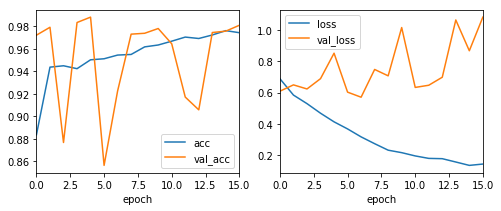

In [69]:
df=pd.DataFrame.from_dict(training.history)
df.columns=[ "Avg_Prec","acc","auc","loss", "val_acc", "val_loss"]
df.index.name='epoch'
print(df)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3));

df[["acc", "val_acc"]].plot(ax=axes[0]);
df[["loss", "val_loss"]].plot(ax=axes[1]);
plt.show()

In [72]:
basicmodel.load_weights('han_smr')
pred = basicmodel.predict(X_test)
ap_test = average_precision_score(Y_test, pred)
print("AP: ", ap_test)
auc_test = roc_auc_score(Y_test, pred)
print("AUC: ", auc_test)

AP:  0.18007272269233926
AUC:  0.8103841037505203
